In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time
import os
import sys
sys.path.append('../../')

from data.processing import get_data

import models

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new
from utils.generic.create_report import save_dict_and_create_report
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
#from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles, plot_ptiles_comp
from viz.fit import plot_all_losses

import yaml

In [ ]:
from os.path import exists, join, splitext

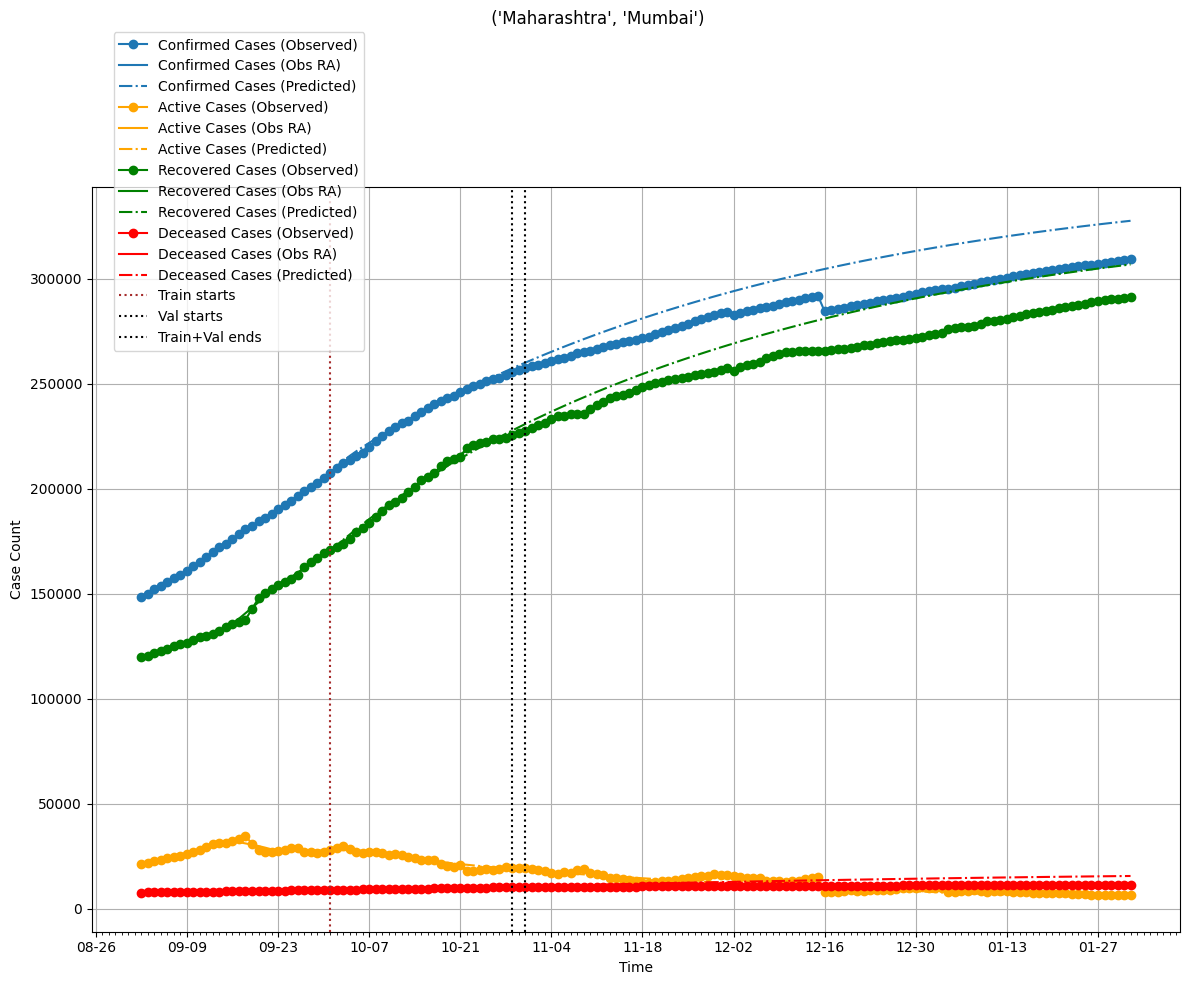

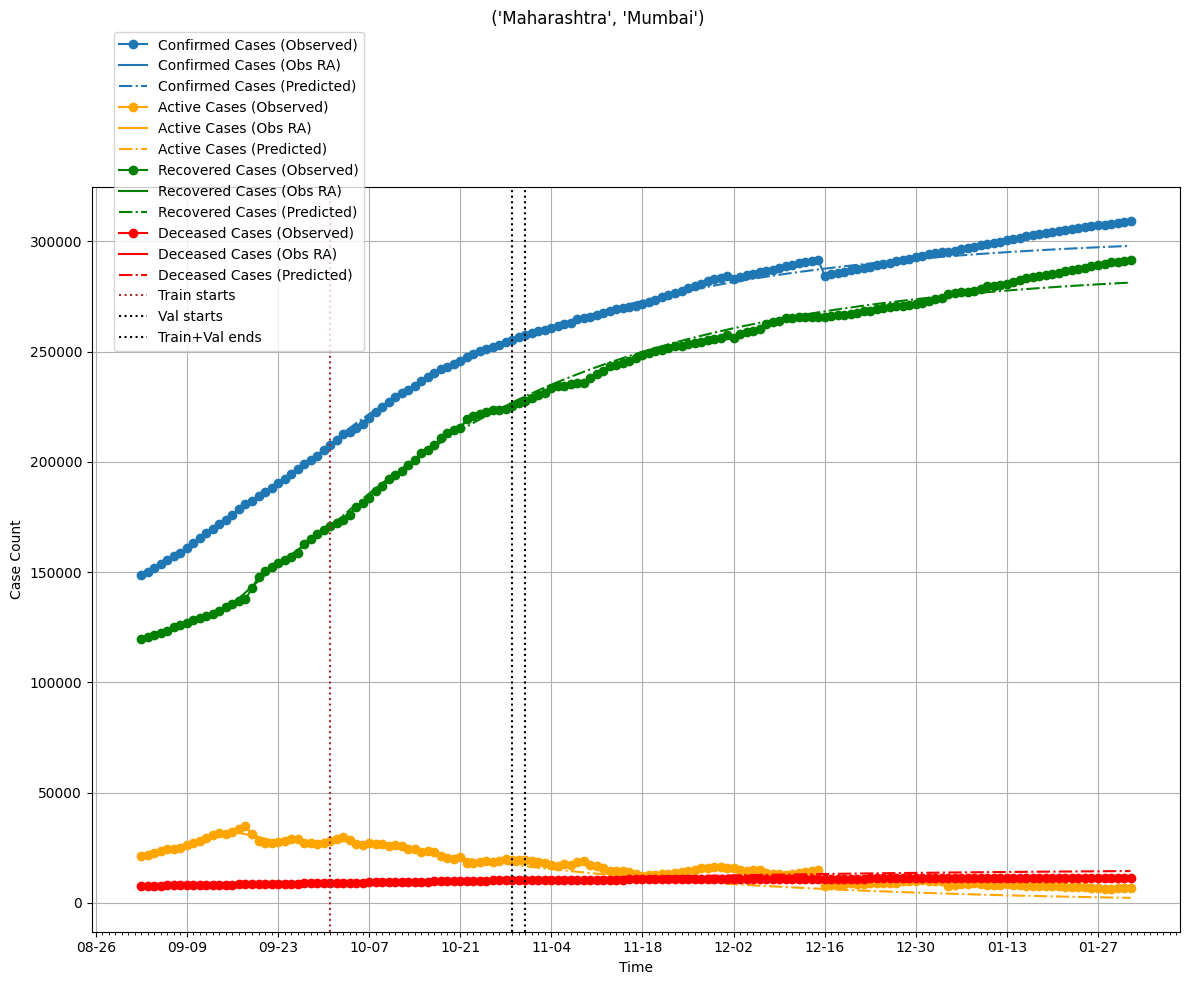

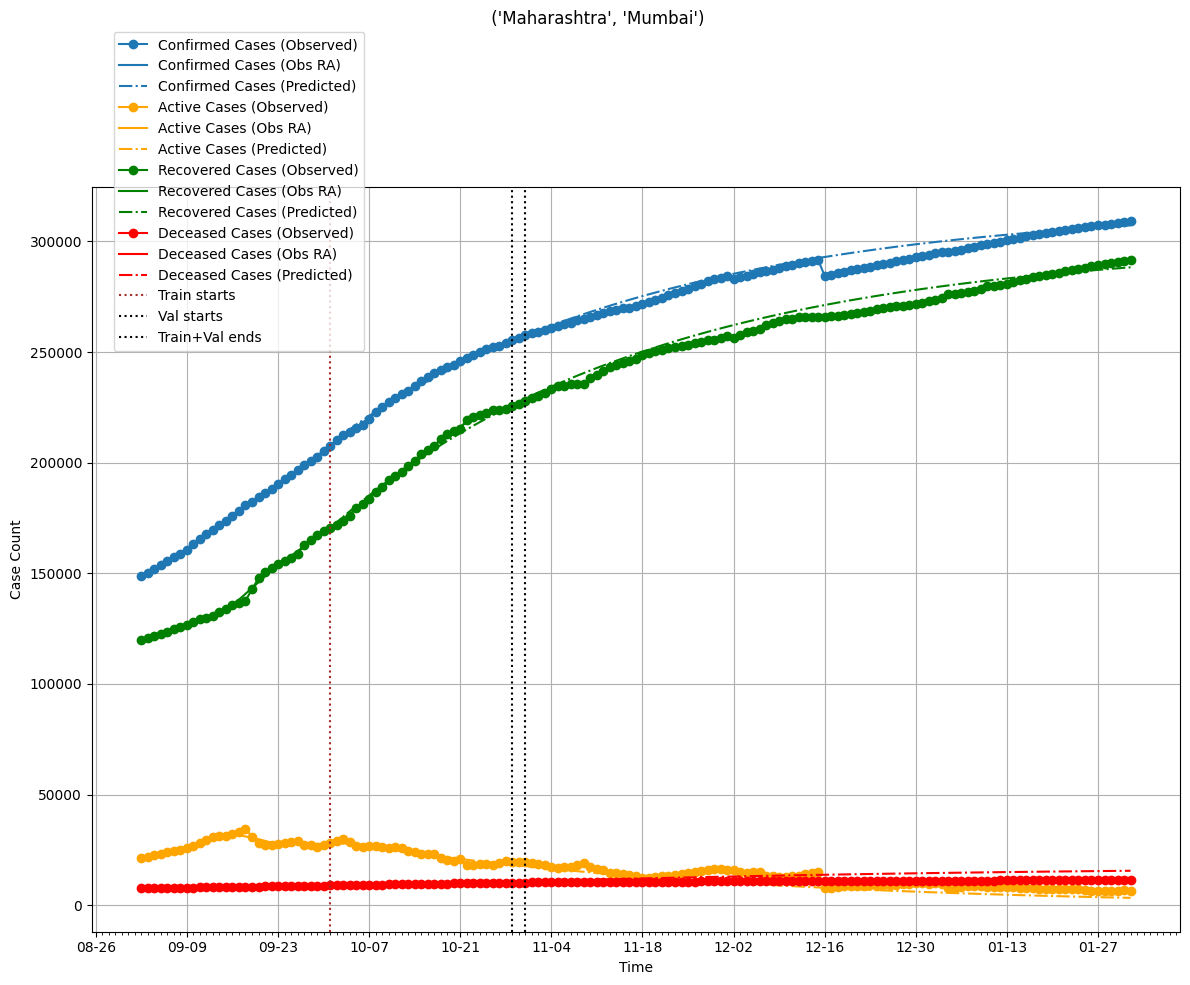

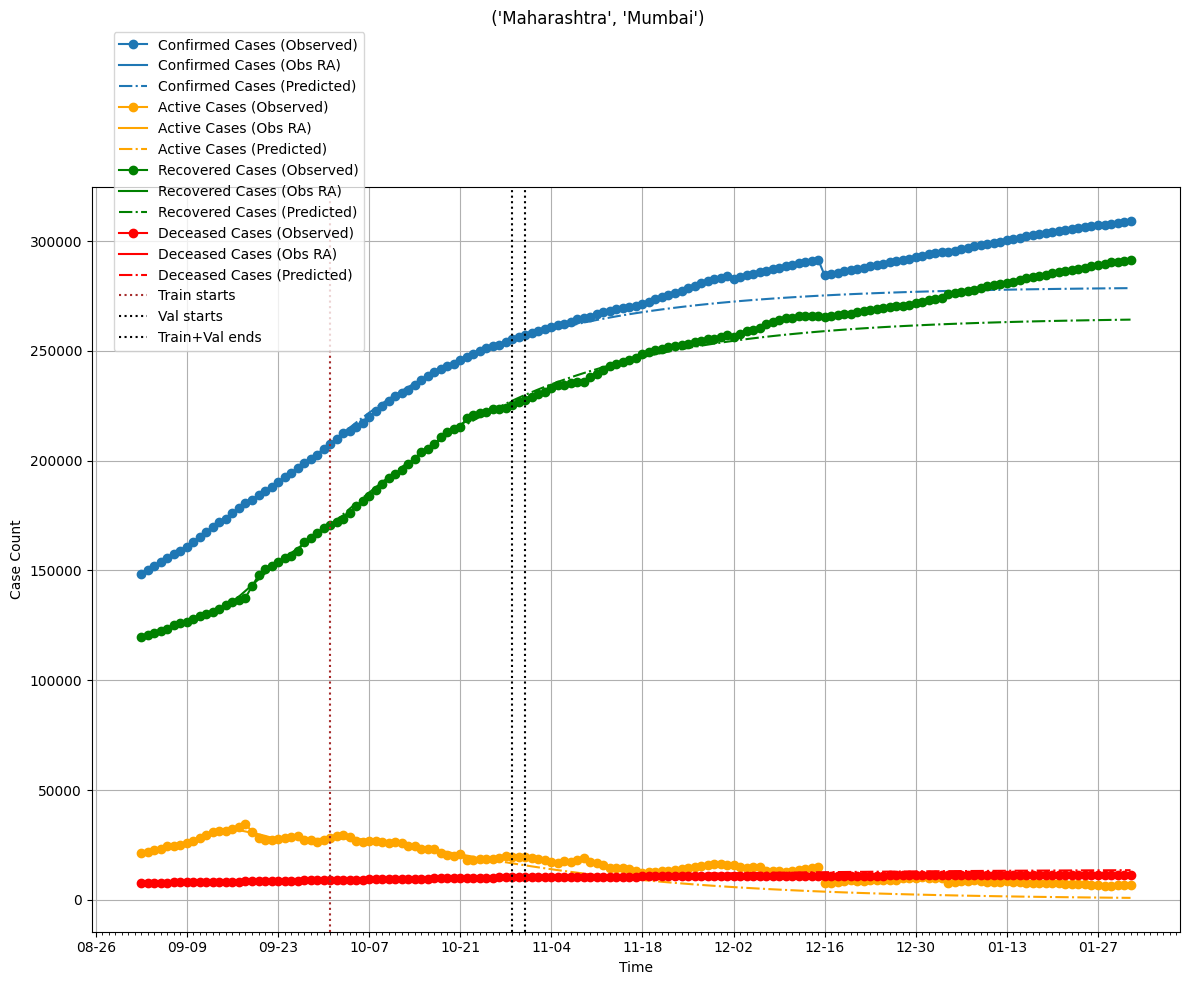

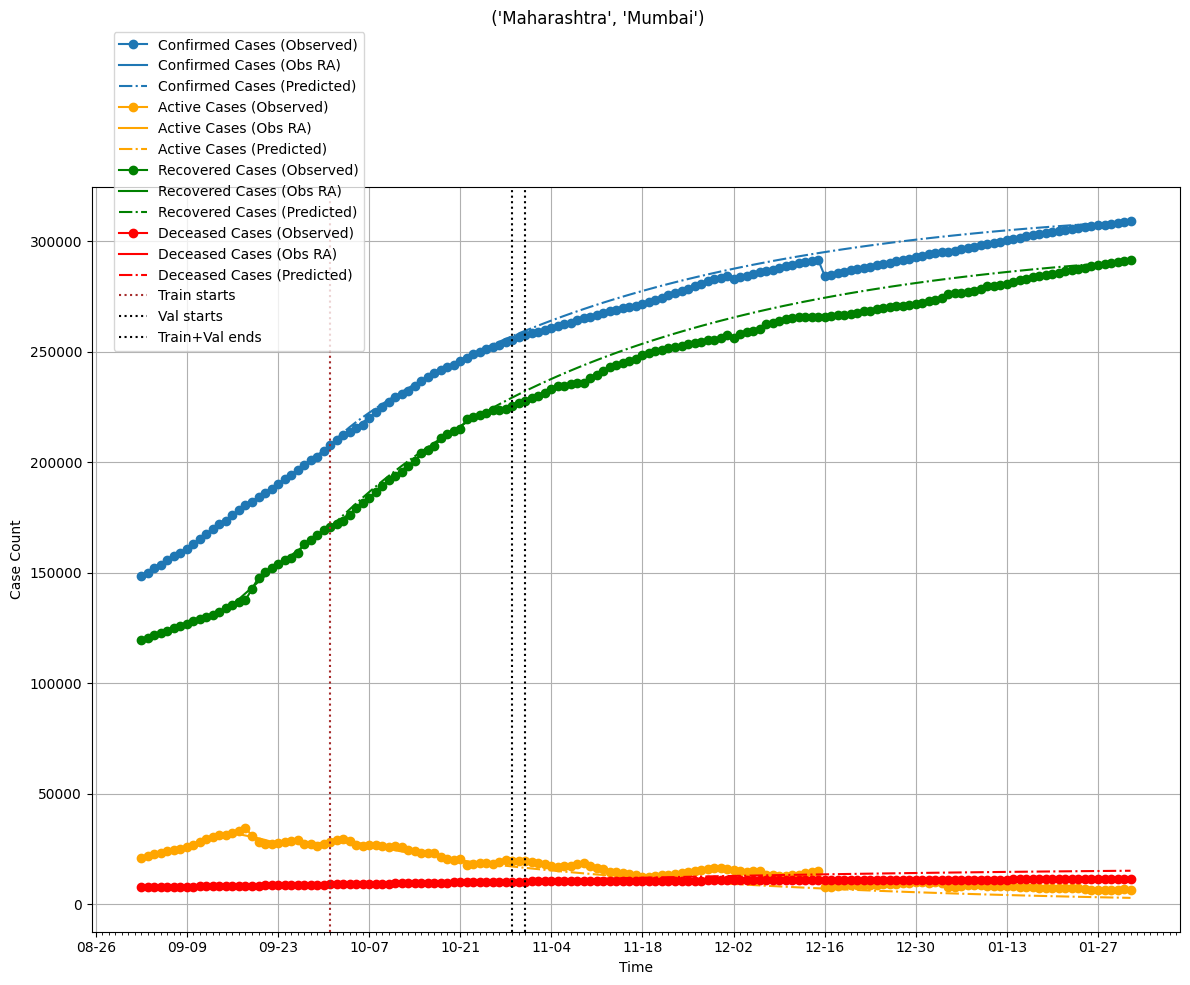

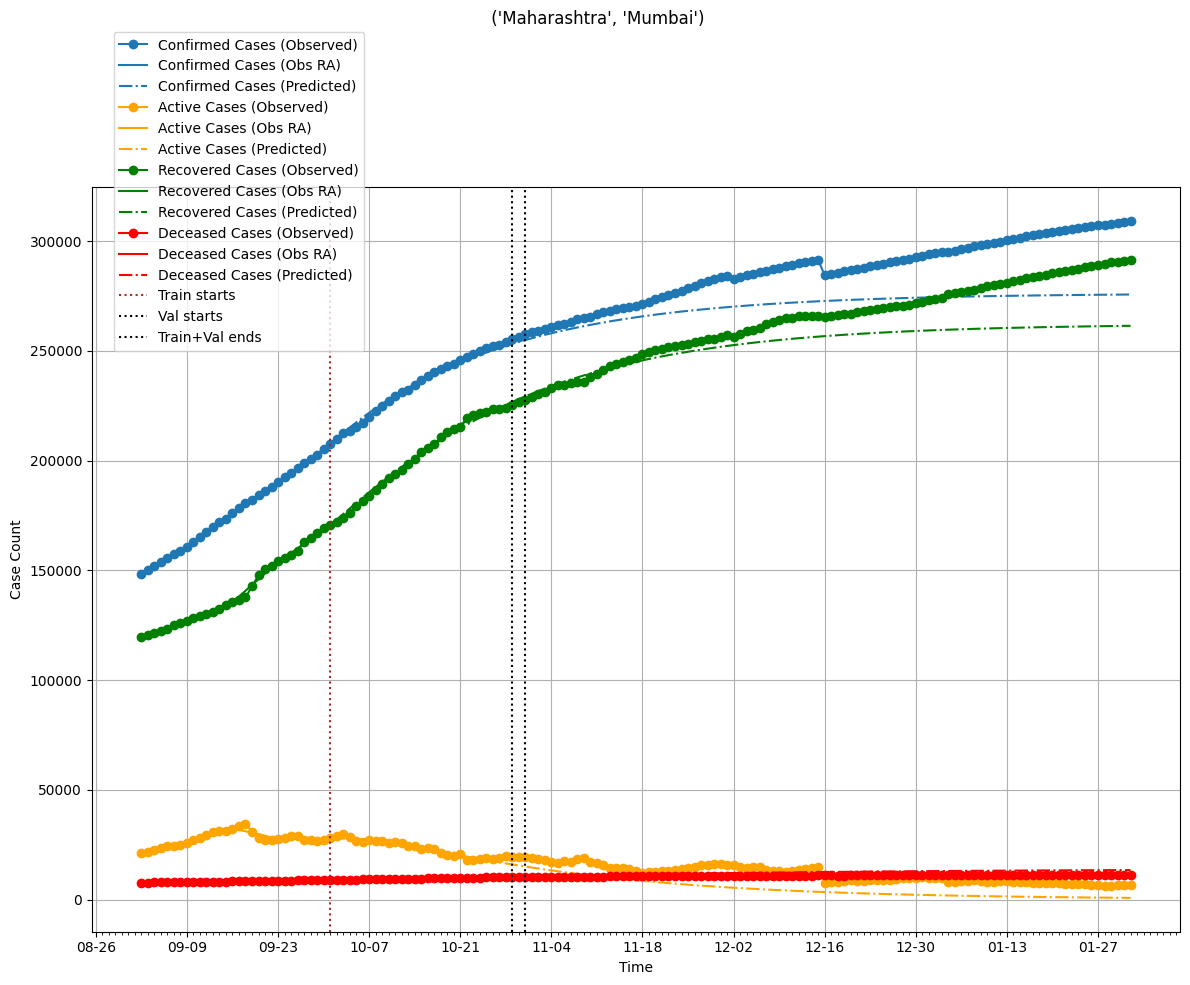

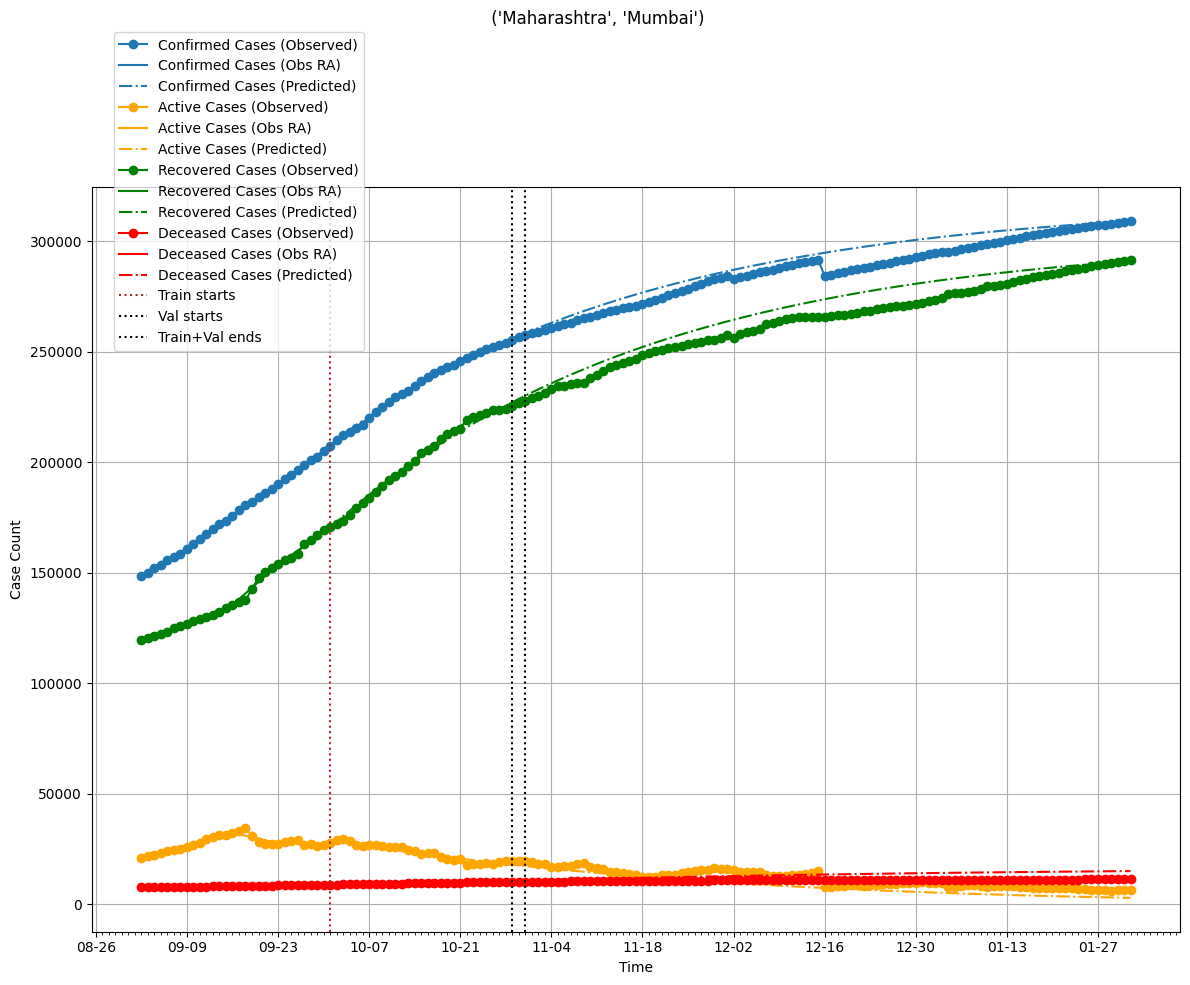

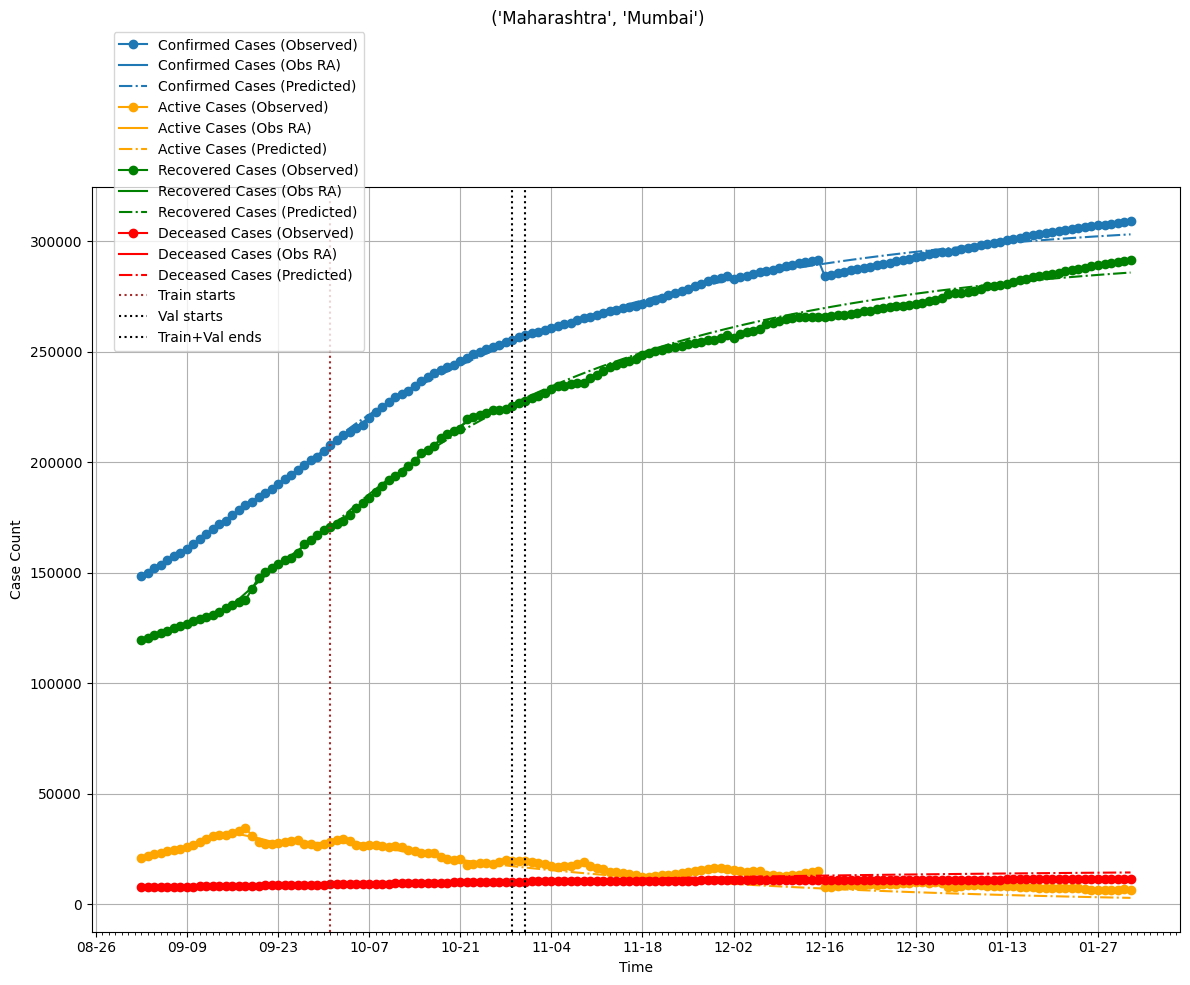

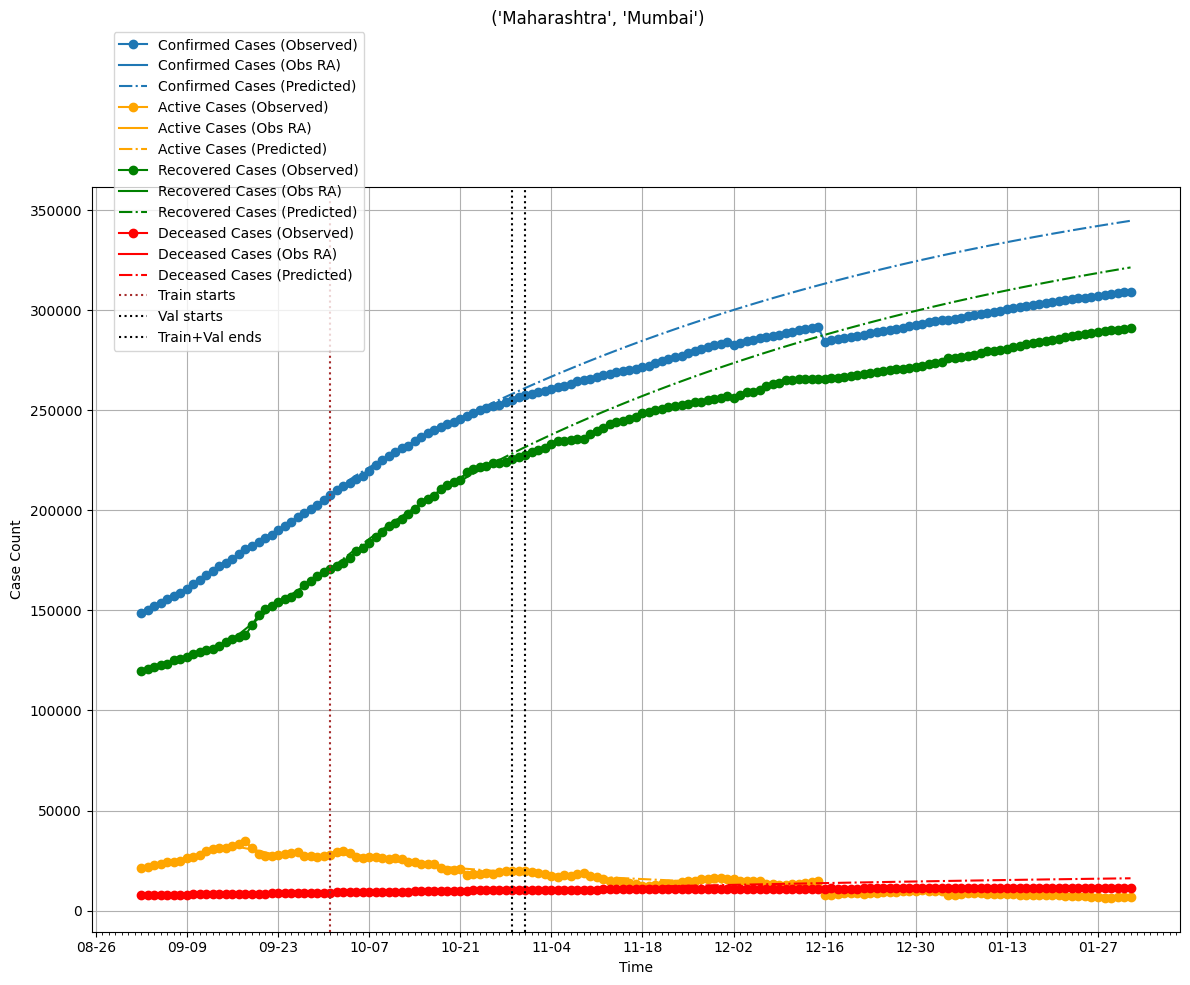

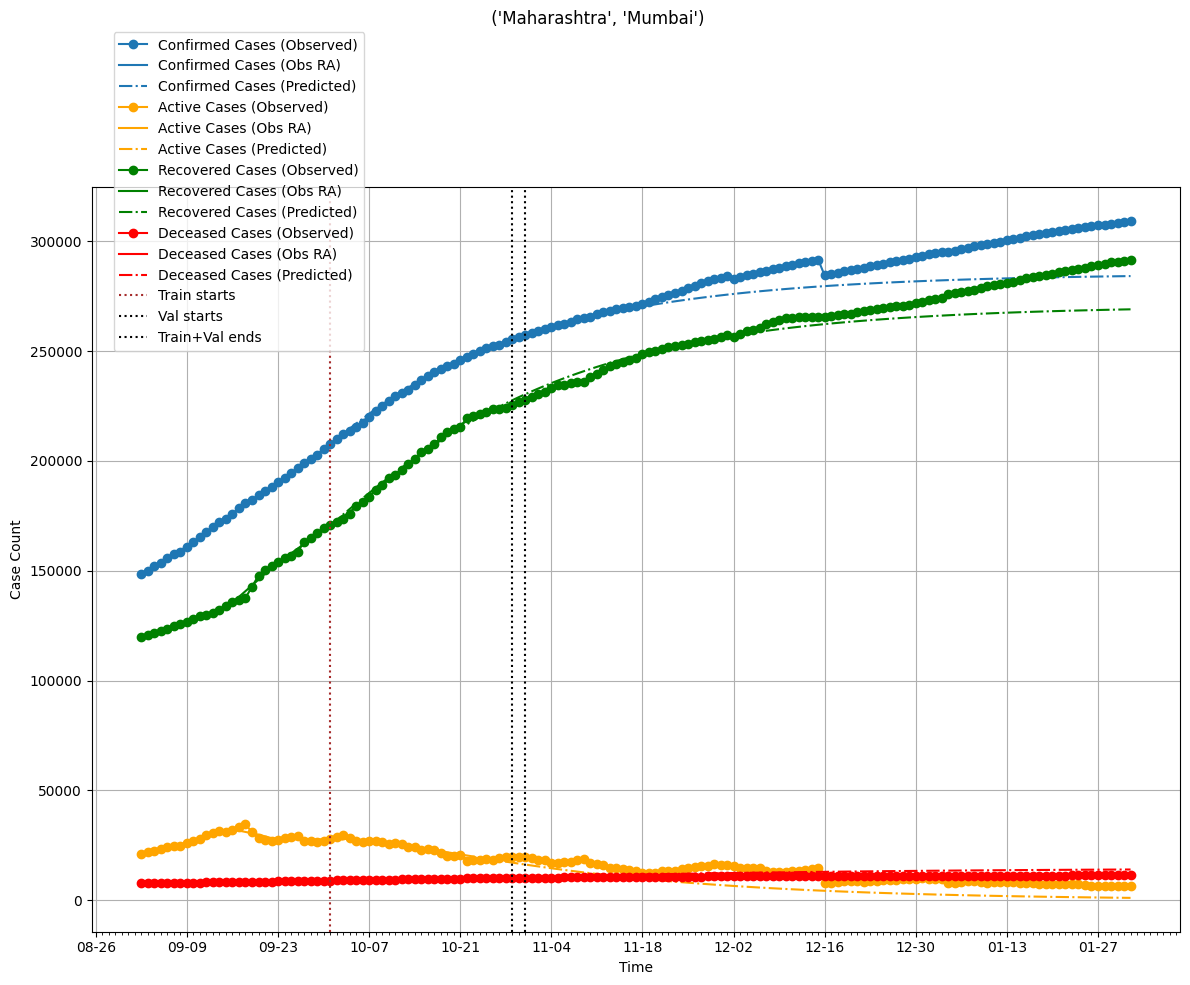

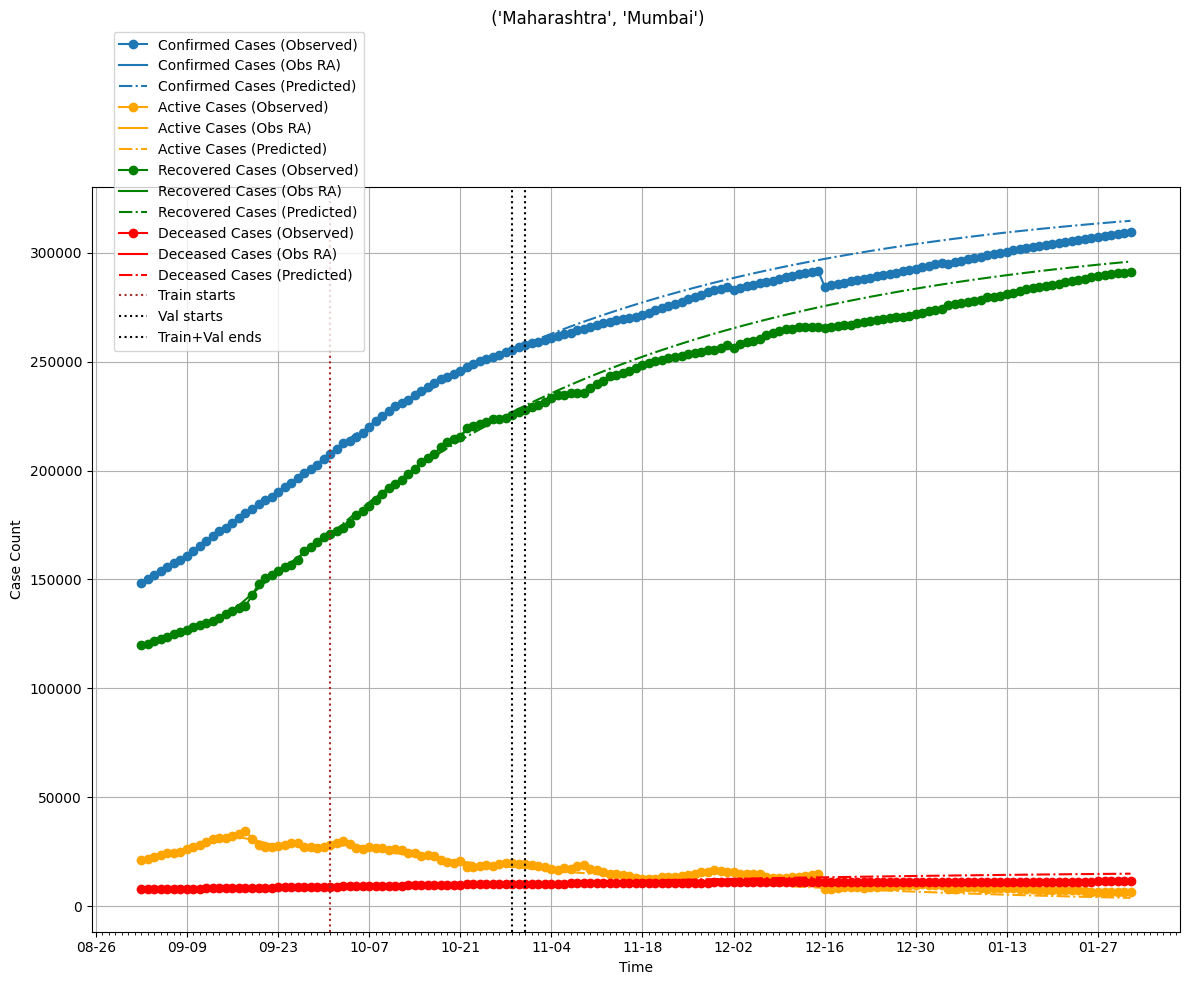

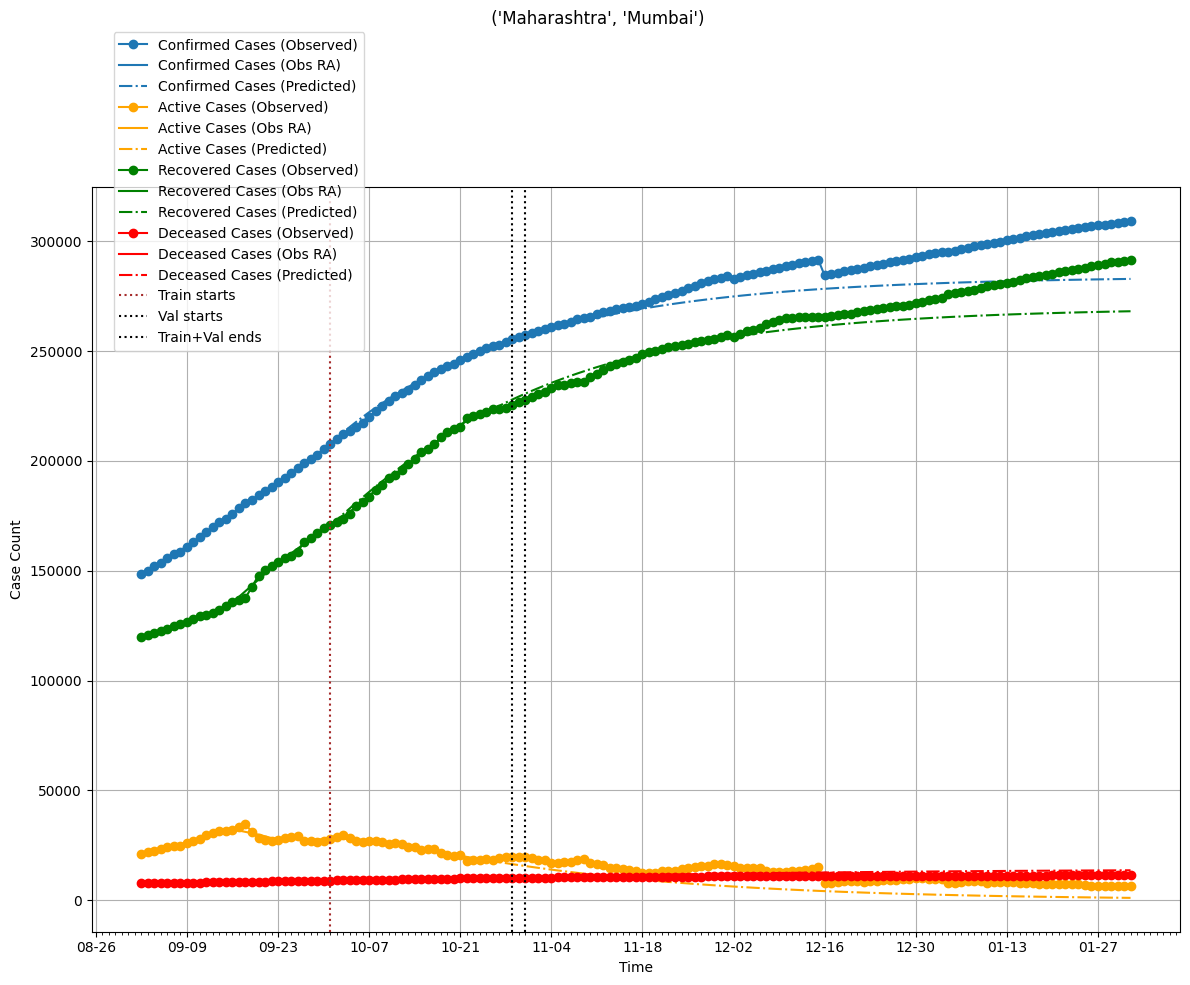

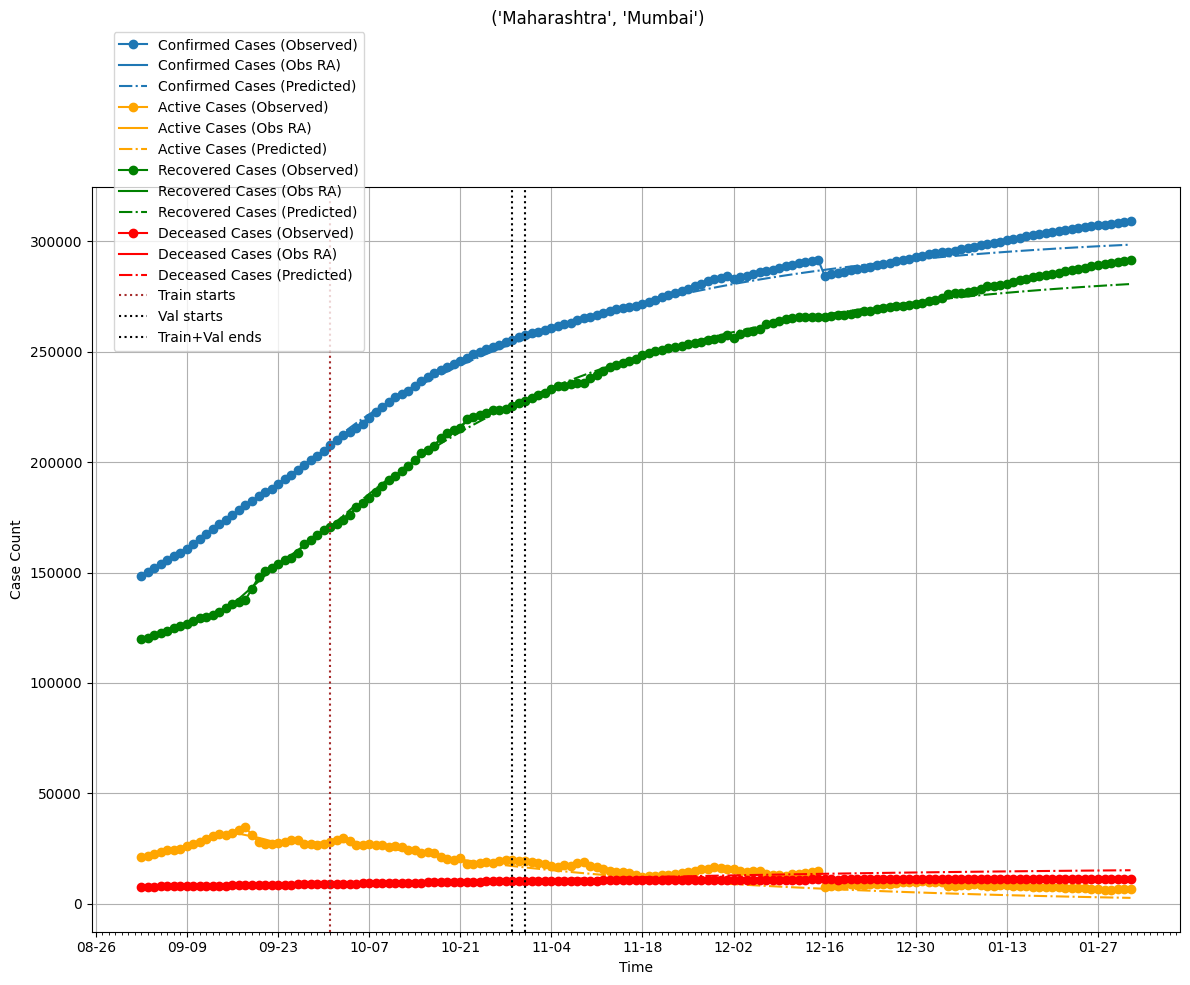

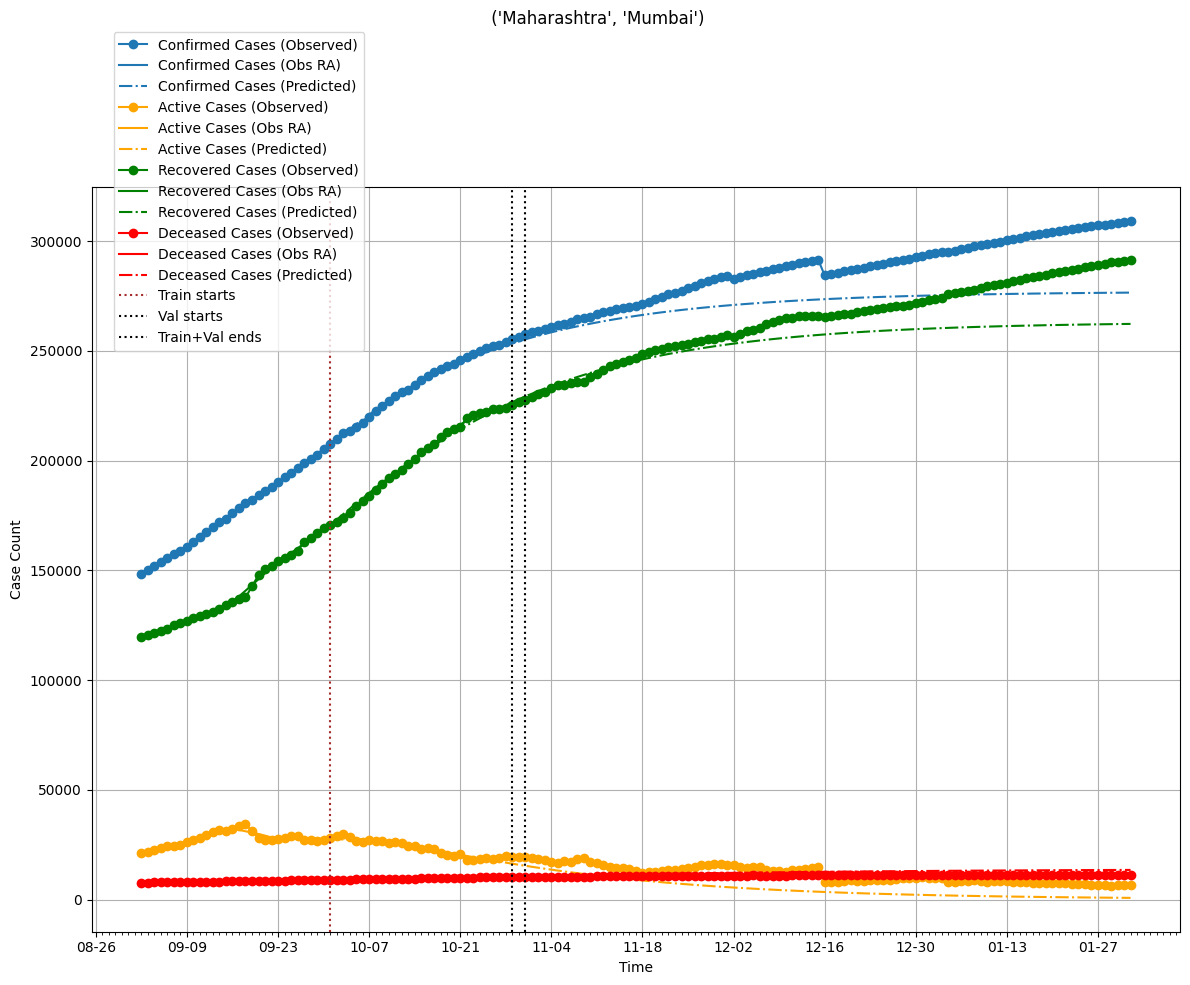

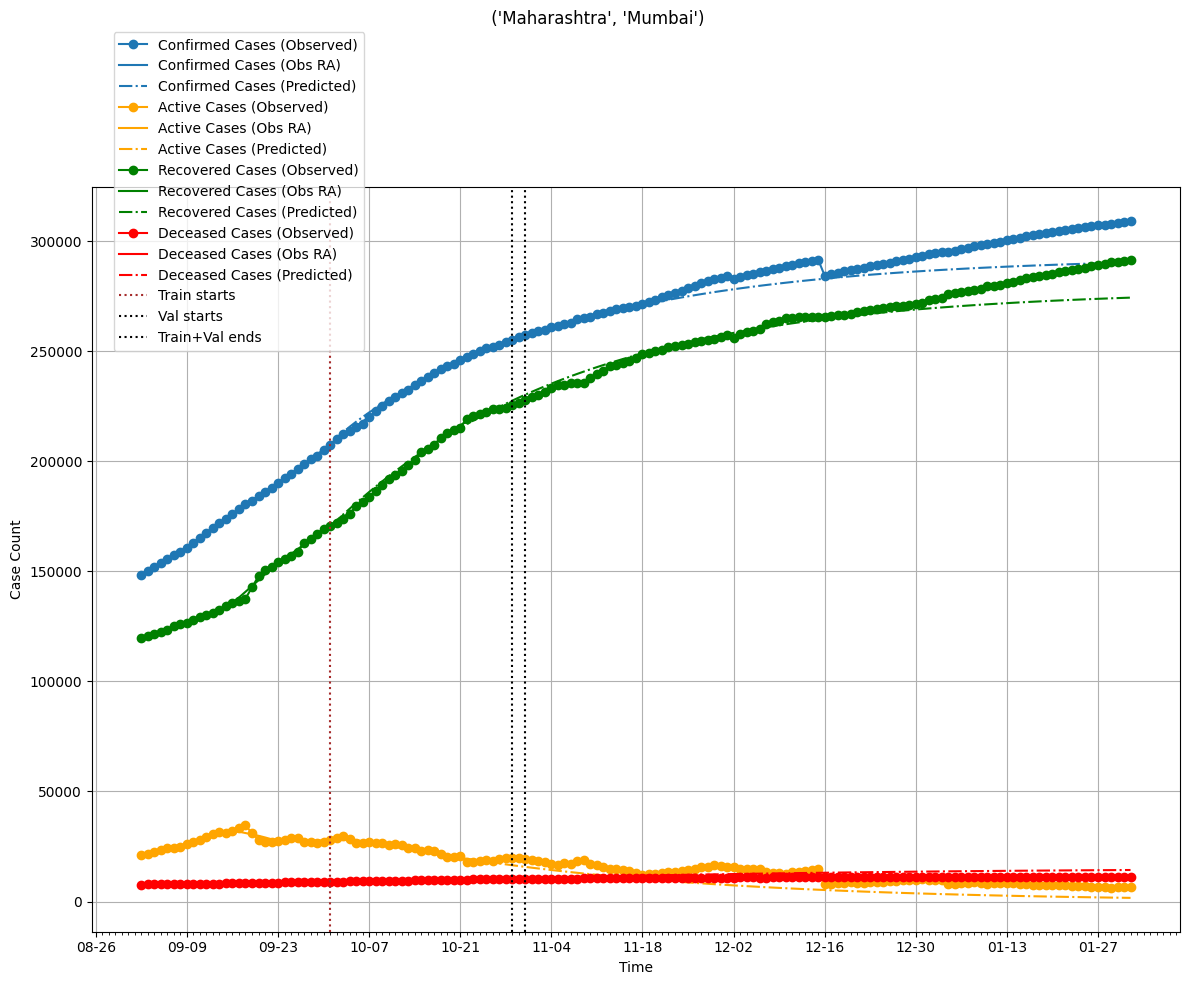

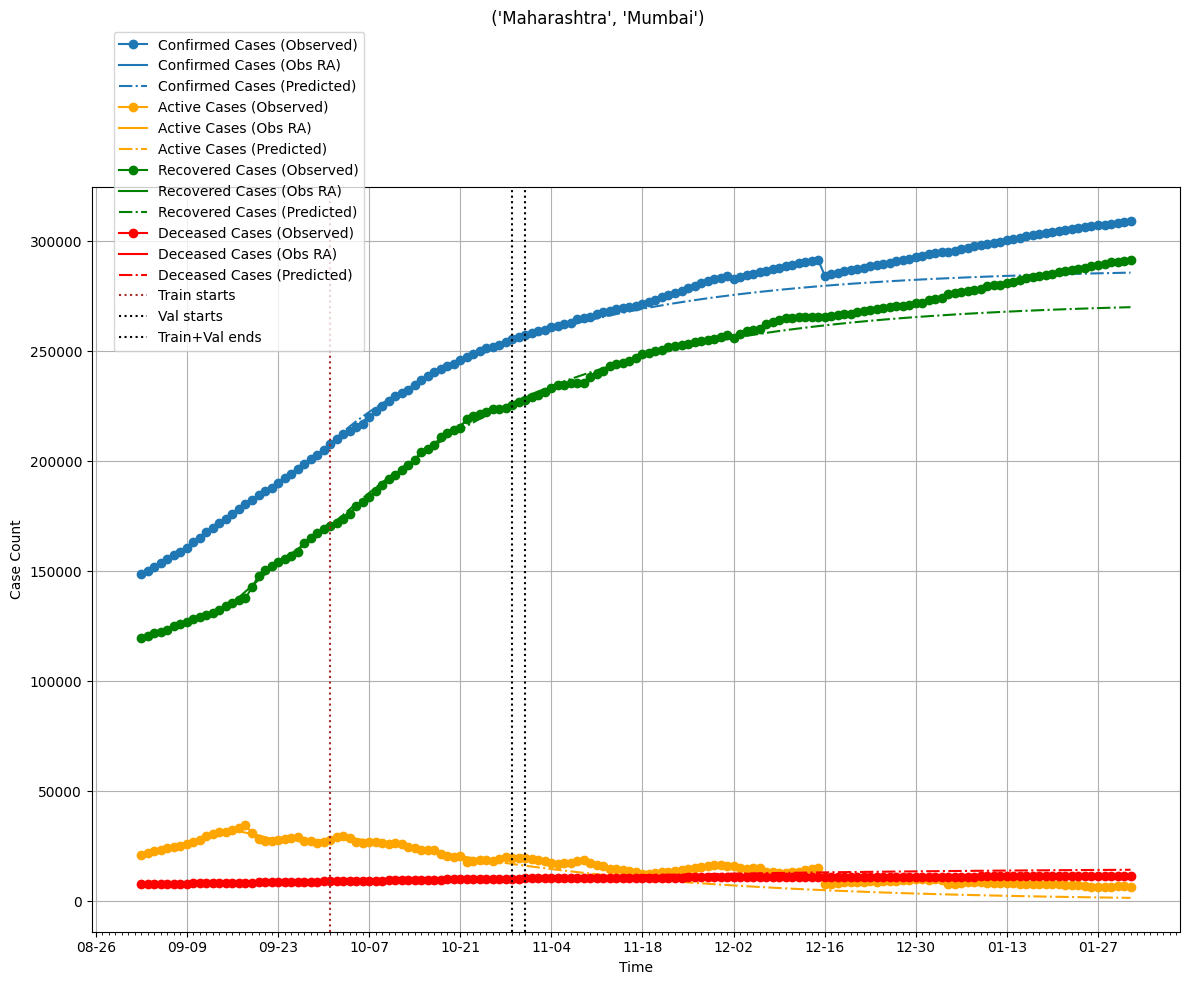

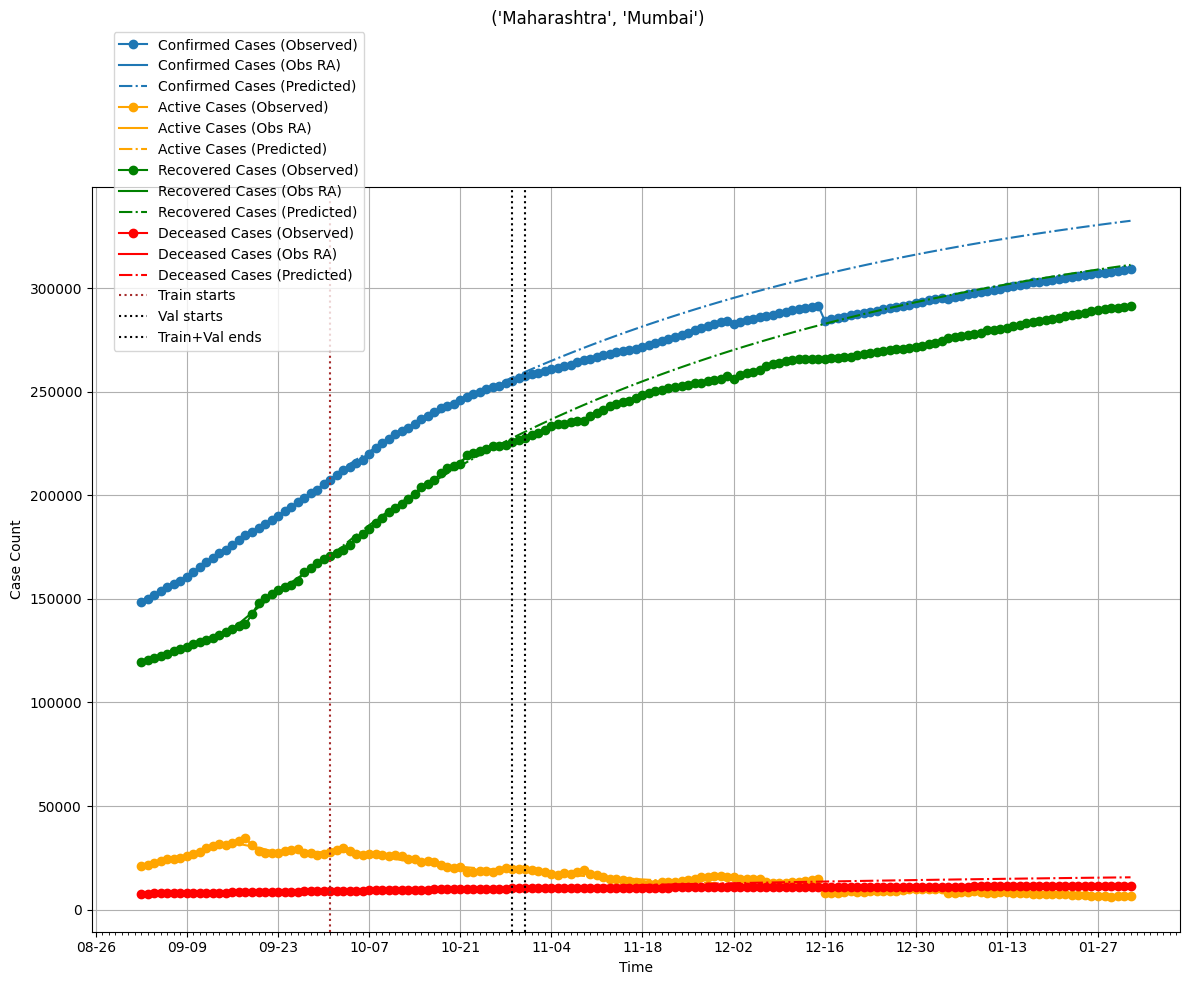

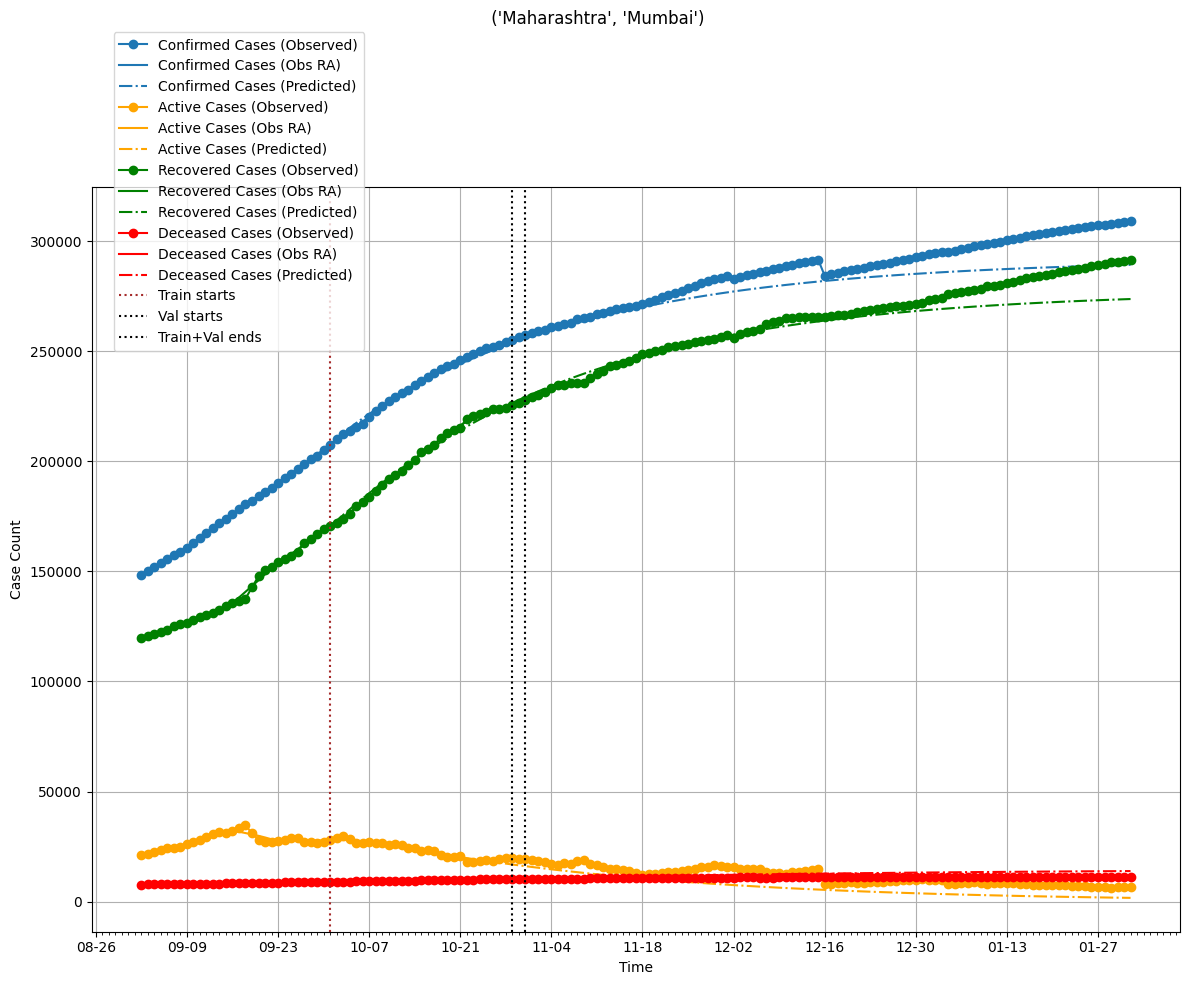

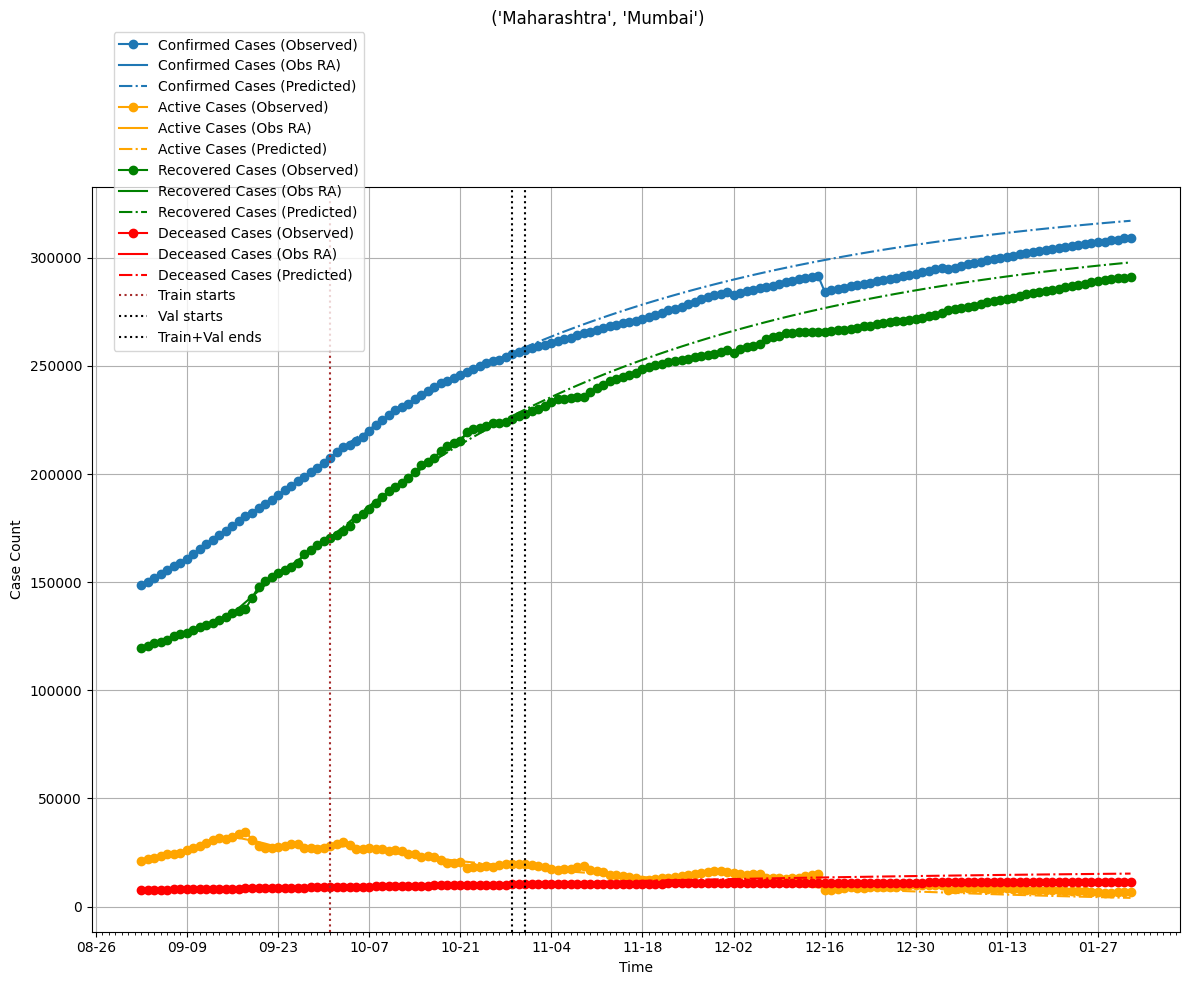

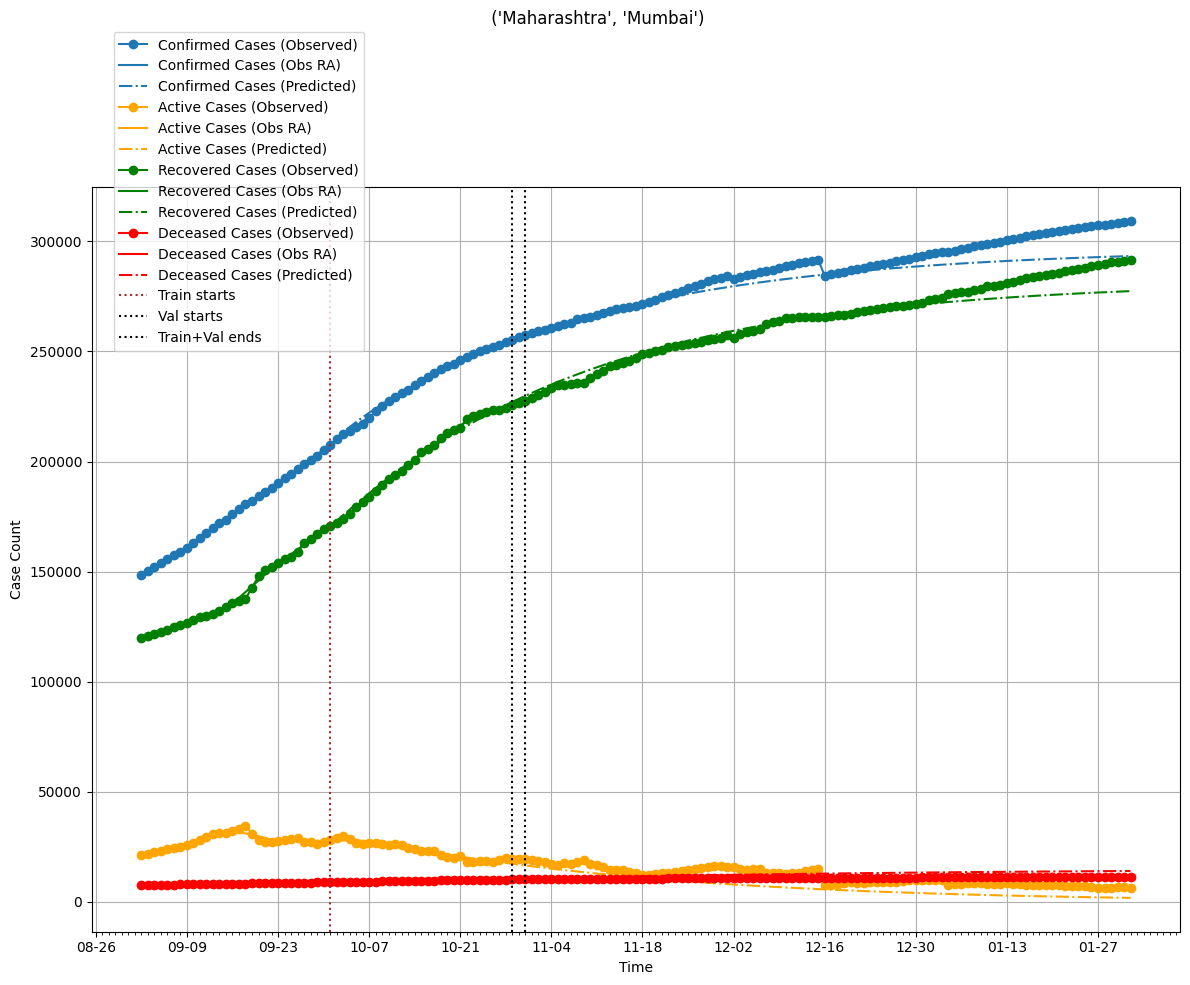

In [4]:
import pickle as pkl
with open('../../misc/predictions/test_mumbai_logdiff.pickle', 'rb') as handle:
    PD = pkl.load(handle)

In [5]:
loss_type = 'ensemble'
# Can be 'test','train','ensemble'
import pandas as pd

In [6]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        if loss_type in ['train','test']:
            df = model_dict['m1']['df_loss'][loss_type]
            df['agg'] = df.mean()
            df_compiled[model].append(df)
        else:
            df = model_dict['ensemble_mean_forecast']['df_loss']
            df['agg'] = np.mean(list(df.values()))
            df2 = {comp:df[comp] for comp in which_compartments}
            df_compiled[model].append(df2)
stats = {}

stats['MCMC'] = (pd.DataFrame(df_compiled['MCMC']).describe()).loc[['mean','std']]
stats['BO'] = (pd.DataFrame(df_compiled['BO']).describe()).loc[['mean','std']]

In [7]:
pd.DataFrame(df_compiled['MCMC'])

,total,active,recovered,deceased,agg
0,0.804998,13.617666,1.485811,6.003184,5.477915
1,0.771191,13.291326,1.192352,5.219831,5.118675
2,0.774725,13.257642,0.802131,5.813181,5.161920
3,0.792842,13.851222,1.454735,5.973554,5.518088
4,0.811270,14.847205,1.484972,6.307223,5.862668
5,0.932311,13.066672,1.849097,5.221735,5.267454
6,0.821633,13.671557,0.752461,5.496579,5.185557
7,0.802379,13.758838,1.433157,5.305061,5.324859
8,0.753411,12.647597,0.858044,6.226306,5.121340
9,0.780909,13.744117,1.292057,4.777653,5.148684


In [8]:
stats["MCMC"]

,total,active,recovered,deceased,agg
mean,0.804567,13.575384,1.260482,5.634431,5.318716
std,0.049417,0.583857,0.357608,0.504388,0.238943


In [9]:
X = pd.DataFrame(df_compiled["MCMC"]).assign(model = 'MCMC')
Y = pd.DataFrame(df_compiled["BO"]).assign(model = 'BO')
Z = pd.concat([X,Y])
Z.to_csv('ensemble_compiled',index= False)

In [10]:
import csv
import sys
mydict = df_compiled                                      
writer = None
for (model, losses) in mydict.items():
    for	(i, l) in enumerate(losses):
        print(l)
        row = dict(l)
        row.update({
        'model': model,
        'run': i,
        })
    if writer is None:
        writer = csv.DictWriter(sys.stdout, fieldnames=row)
        writer.writeheader()
        writer.writerow(row)

{'total': 0.8049980994715146, 'active': 13.617666393801745, 'recovered': 1.4858109869796043, 'deceased': 6.003183689960702, 'agg': 5.477914792553391}
{'total': 0.7711910955382566, 'active': 13.291325792681413, 'recovered': 1.1923522785245586, 'deceased': 5.219831049429057, 'agg': 5.1186750540433215}
{'total': 0.77472468725964, 'active': 13.25764197030962, 'recovered': 0.8021309859203591, 'deceased': 5.813181213557664, 'agg': 5.1619197142618205}
{'total': 0.7928418764528866, 'active': 13.85122247630556, 'recovered': 1.4547349630366522, 'deceased': 5.973554028341128, 'agg': 5.518088336034056}
{'total': 0.8112699898624689, 'active': 14.847204910958697, 'recovered': 1.4849721730188705, 'deceased': 6.307223149144671, 'agg': 5.862667555746177}
{'total': 0.9323109573057997, 'active': 13.06667232812127, 'recovered': 1.8490965760180937, 'deceased': 5.221735202735084, 'agg': 5.267453766045061}
{'total': 0.8216326007395646, 'active': 13.671556889219127, 'recovered': 0.7524606361474238, 'deceased'

In [11]:
writer

In [12]:
a=pd.DataFrame(df_compiled)
a.to_csv(loss_type)
#Chose between MCMC and BO

In [13]:
stats['MCMC']

,total,active,recovered,deceased,agg
mean,0.804567,13.575384,1.260482,5.634431,5.318716
std,0.049417,0.583857,0.357608,0.504388,0.238943


In [14]:
save = True

In [15]:
from viz.fit import plot_histogram


In [16]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [108]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 15,
    'font.family': 'Palatino',
})

In [109]:
config_filename = 'default.yaml'
config = read_config(config_filename)

In [110]:
import pickle as pkl
with open('../../misc/predictions/mcmc_total.pickle', 'rb') as handle:
    PD_t = pkl.load(handle)
with open('../../misc/predictions/mcmc_active.pickle', 'rb') as handle:
    PD_a = pkl.load(handle)
with open('../../misc/predictions/mcmc_recovered.pickle', 'rb') as handle:
    PD_r = pkl.load(handle)
with open('../../misc/predictions/mcmc_deceased.pickle', 'rb') as handle:
    PD_d = pkl.load(handle)

In [111]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [112]:
legend_elements = [
    Line2D([0], [0], ls='-', color='tab:orange', label='ABMA EM'),
    Line2D([0], [0], ls='-',color='tab:blue', label='MCMC EM'),
    Patch(facecolor='tab:orange', label= 'ABMA 95\% CI',alpha = 0.2),
    Patch(facecolor='tab:blue', label='MCMC 95\% CI',alpha = 0.2),
    Line2D([0], [0], ls='--',color='red', label='Observed',lw = 3.5),
]



total
active
recovered
deceased


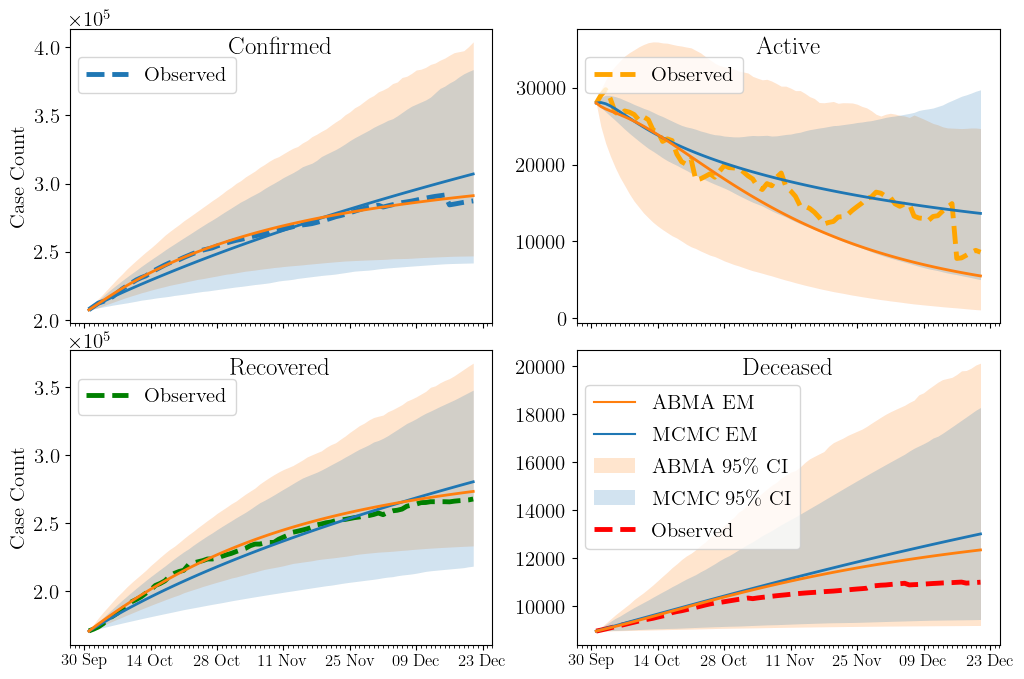

In [115]:
fig,axs = plt.subplots(figsize=(12,8),nrows=2,ncols=2) 
plot_ptiles_comp(PD_t, compartment=config['forecast']['plot_ptiles_for_columns'][0],ax=axs.flat[0])
axs.flat[0].ticklabel_format(style='sci', axis='y', scilimits=(0, 5))
plot_ptiles_comp(PD_a, compartment=config['forecast']['plot_ptiles_for_columns'][1],ax=axs.flat[1])
axs.flat[1].set_ylabel('')
plot_ptiles_comp(PD_r, compartment=config['forecast']['plot_ptiles_for_columns'][2],ax=axs.flat[2])
axs.flat[2].ticklabel_format(style='sci', axis='y', scilimits=(0, 5))
axs.flat[2].tick_params(axis='x', labelsize=12)
plot_ptiles_comp(PD_d, compartment=config['forecast']['plot_ptiles_for_columns'][3],ax=axs.flat[3])
axs.flat[3].tick_params(axis='x', labelsize=12)
axs.flat[3].set_ylabel('')
axs.flat[3].legend(handles=legend_elements,loc =[0.02,.325] )
for ax in axs[0, :]:
    ax.xaxis.set_ticklabels([])
plt.subplots_adjust(hspace=0.09)
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/CI.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

In [52]:
which_compartments = ['total', 'active', 'recovered', 'deceased','agg']

In [53]:
df_compiled = {"MCMC":[],"BO":[]}
for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = model_dict['m1']['df_loss']['train']
        df['agg'] = df.mean()
        df_compiled[model].append(df)
        

In [25]:
import pandas as pd
from viz.fit import comp_bar

In [96]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 13,
    'font.family': 'Palatino',
})

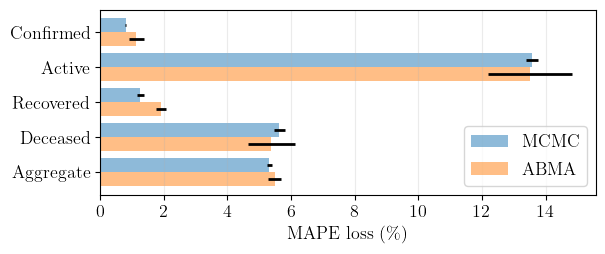

In [107]:
fig,ax = plt.subplots(figsize = [6.4, 2.4])
comp_bar(PD,'ensemble')
plt.show()
fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/ensemble_bar2.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

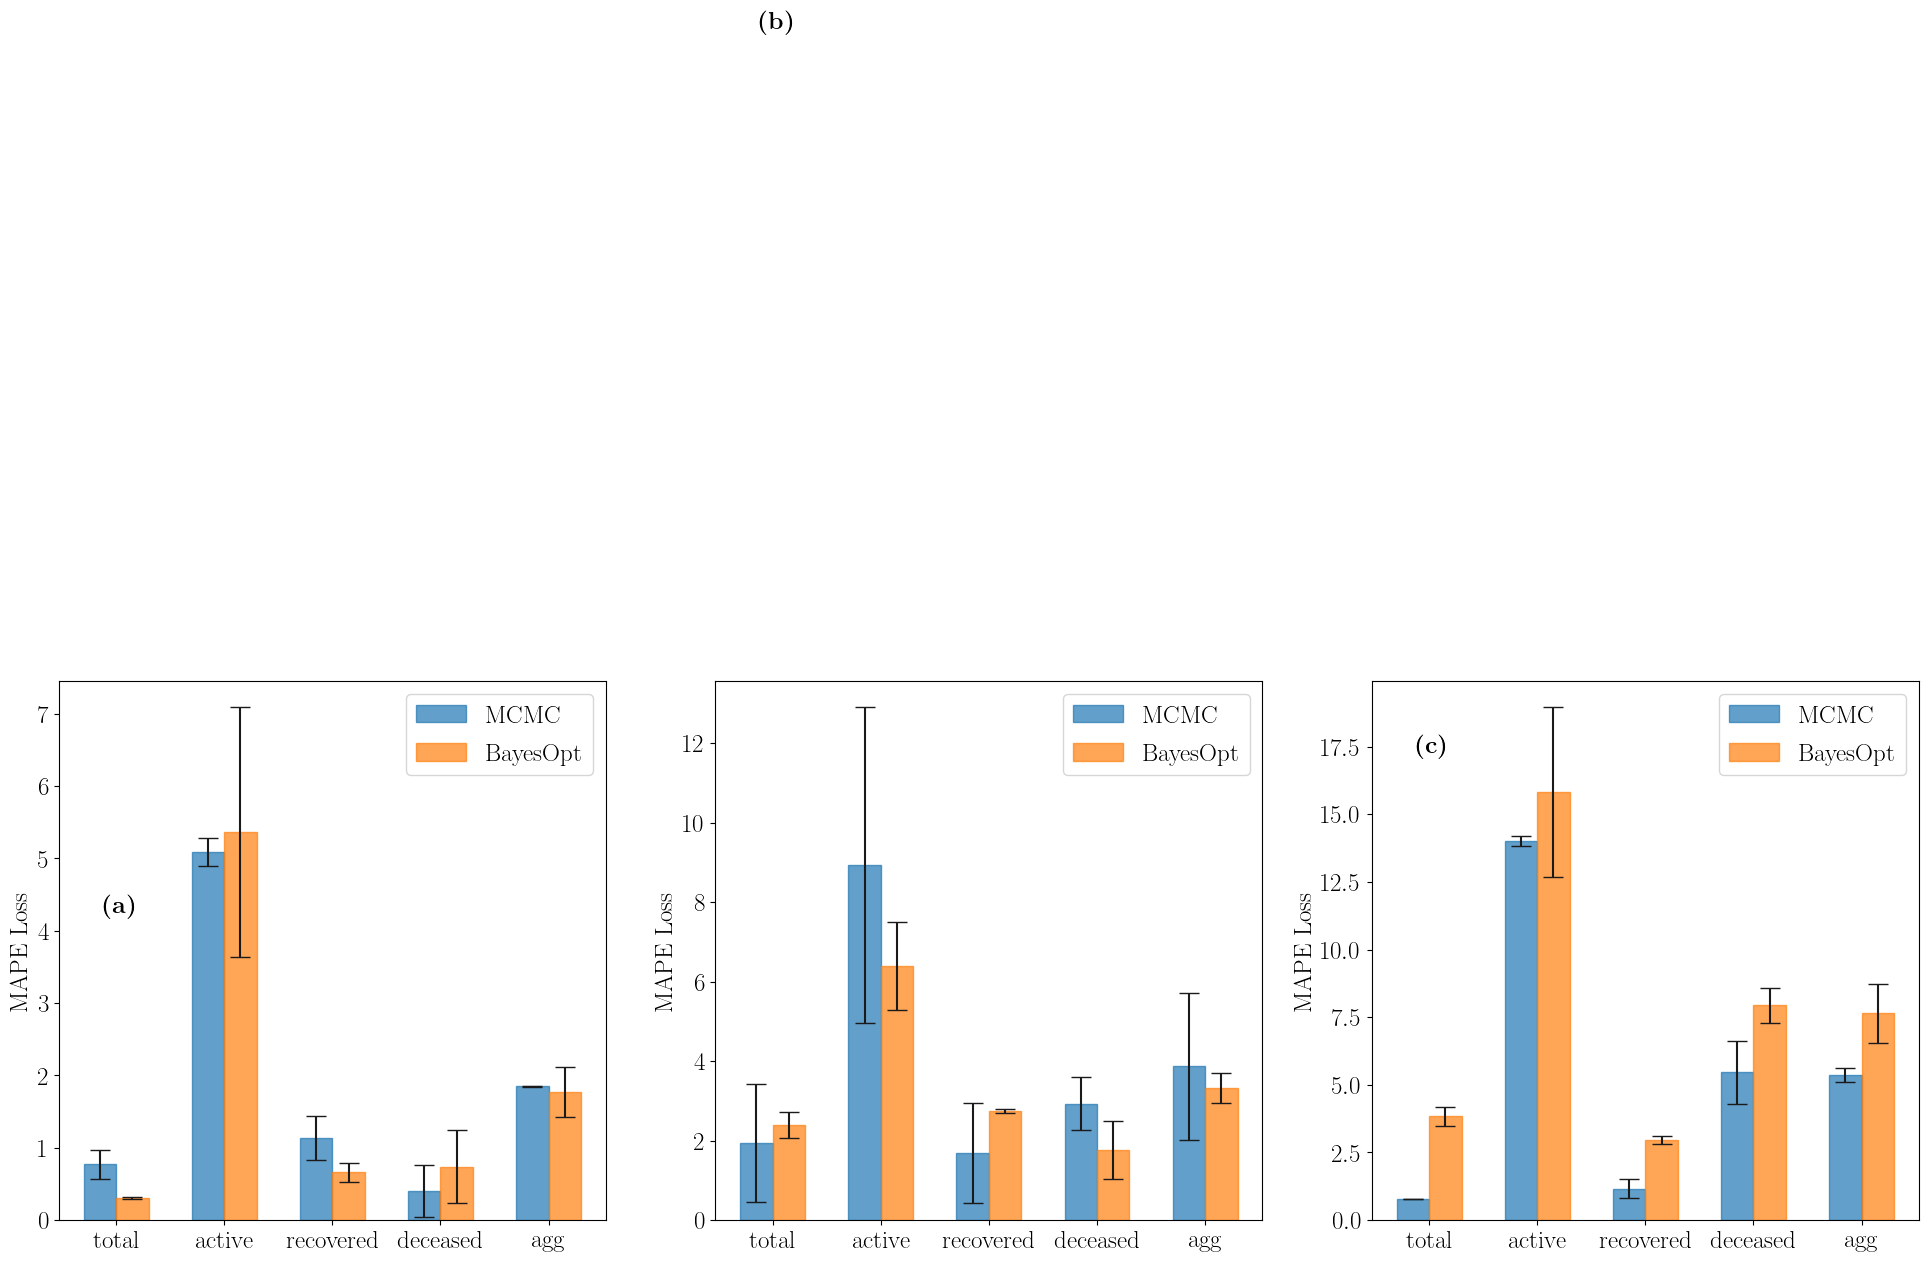

In [15]:
fig,axs = plt.subplots(figsize=(24,7),nrows=1,ncols=3)
comp_bar(PD,'train',axs.flat[0])
comp_bar(PD,'test',axs.flat[1])
comp_bar(PD,'ensemble',axs.flat[2])
# fig.suptitle('Comparision of Fitting with BO and MCMC', fontsize=16)
plt.show()
if save:
    fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/Bar_plots.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)

## Percentile Loss

In [56]:
df_compiled_perc_loss = {"MCMC":[],"BO":[]}
percentiles = []

for run,run_dict in PD.items():
    for model,model_dict in run_dict.items():
        df = {}
        percentiles = list(model_dict['uncertainty_forecasts'].keys())
        for perc,perc_dict in model_dict['uncertainty_forecasts'].items():
            df[perc] = perc_dict['df_loss_perc']['test']['total']
        df_compiled_perc_loss[model].append(df)

In [57]:
stats_perc_MCMC = pd.DataFrame(df_compiled_perc_loss['MCMC']).describe().loc[['mean','std']]
stats_perc_BO = pd.DataFrame(df_compiled_perc_loss['BO']).describe().loc[['mean','std']]

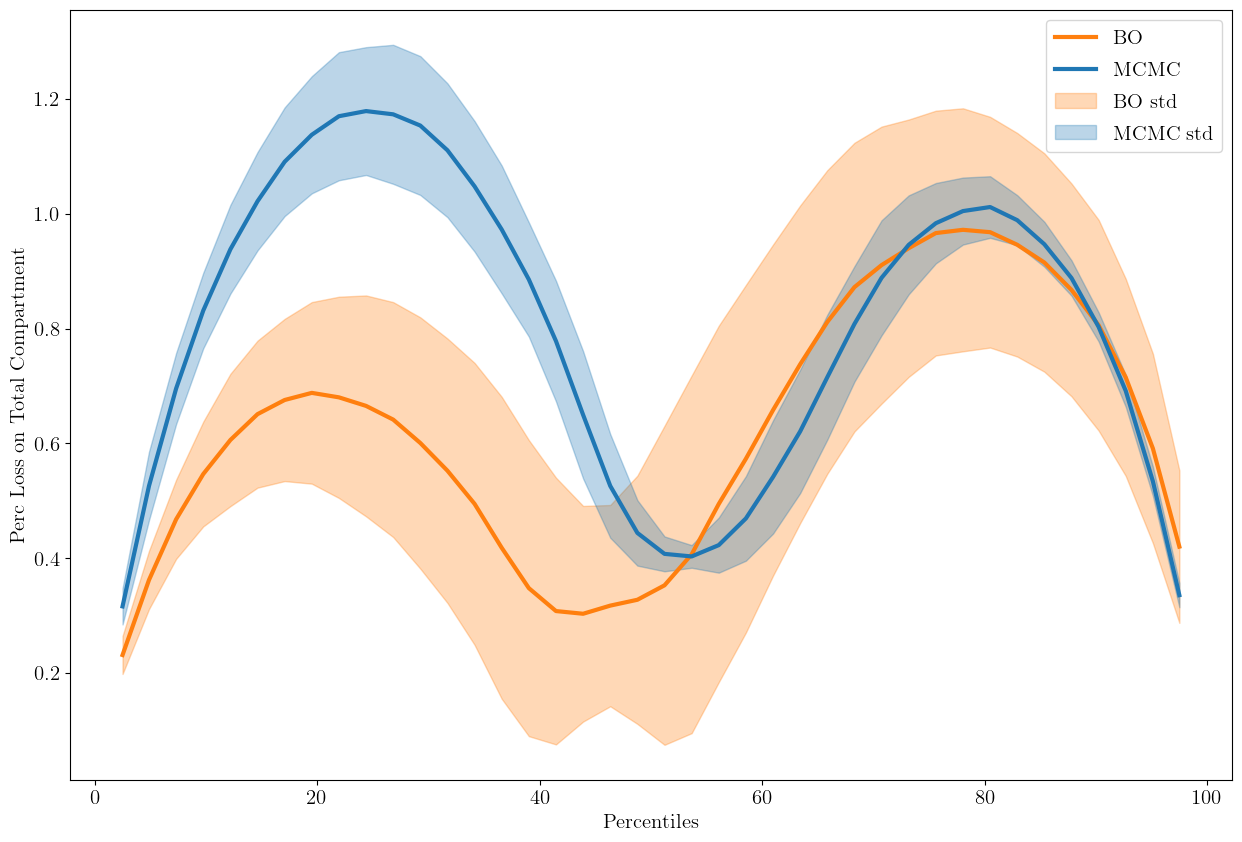

In [58]:
import matplotlib as mpl
barWidth = 0.3

fig = plt.figure(figsize=(15,10))
# plt.errorbar(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'orange',label='BO',yerr =list(stats_perc_BO.loc['std'].values) ,elinewidth =3,capthick =3,barsabove = True)
# plt.errorbar(list(stats_perc_MCMC.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'blue',label = 'MCMC',yerr = list(stats_perc_MCMC.loc['std'].values),elinewidth =3,capthick =3,barsabove = True)
plt.plot(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_BO.loc['mean'].values),color = 'tab:orange',label='BO',lw =3)
plt.plot(list(stats_perc_BO.loc['mean'].keys()),list(stats_perc_MCMC.loc['mean'].values),color = 'tab:blue',label='MCMC',lw =3)

plt.fill_between(list(stats_perc_BO.loc['mean'].keys()),np.array(stats_perc_BO.loc['mean'].values)+np.array(stats_perc_BO.loc['std'].values) ,np.array(stats_perc_BO.loc['mean'].values)-np.array(stats_perc_BO.loc['std'].values),alpha =0.3,color = 'tab:orange',label = 'BO std')
plt.fill_between(list(stats_perc_MCMC.loc['mean'].keys()),np.array(stats_perc_MCMC.loc['mean'].values)+np.array(stats_perc_MCMC.loc['std'].values) ,np.array(stats_perc_MCMC.loc['mean'].values)-np.array(stats_perc_MCMC.loc['std'].values),alpha =0.3,color = 'tab:blue',label = 'MCMC std')              

# general layout
plt.ylabel('Perc Loss on Total Compartment')
plt.xlabel('Percentiles')
# plt.title('Day Wise Percentile Loss Values on Test for 1 November - 21 November')
plt.legend()
plt.show()
if save:
    fig.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/perc_loss_mcmc.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)


In [5]:
from viz.fit import plot_comp_density_plots,plot_histogram

In [6]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.usetex': True,
    'font.size': 20,
    'font.family': 'Palatino',
})

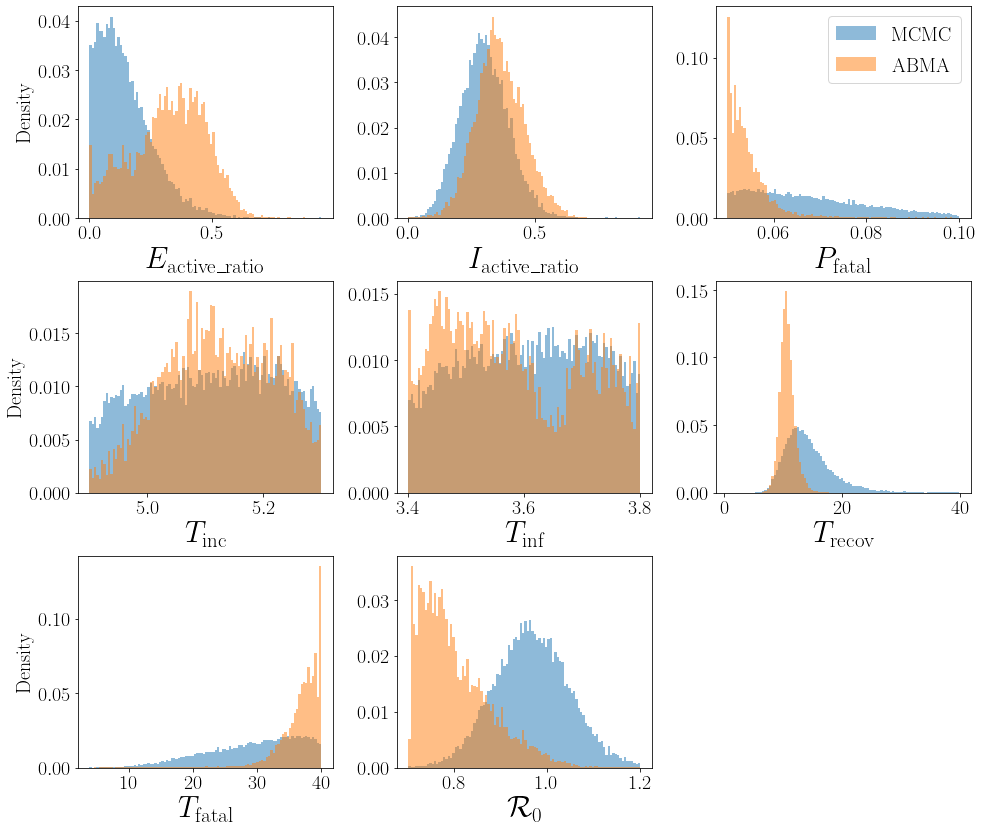

In [7]:
figs, axs = plt.subplots(3,3,figsize=(16,14))
X= {}
plot_comp_density_plots(PD,figs,axs)
axs.flat[8].set_visible(False)
save =False
plt.subplots_adjust(hspace=0.3,wspace = 0.25)
# figs.savefig('/Users/avtansht/Desktop/Desktop/Wadhwani/Plots_final/hist2.pdf',  format='pdf', bbox_inches='tight', pad_inches=0)